# Computing $T$ scores out of Gaussian Mixture Models

- FPKM (Fragments per kilo-base million) data is hard to compare across individuals when it comes to gene expression analysis.
- The log(FPKM) data is often distributed as a bimodal Gaussian mixture model (GMM).
- The GMM values can be transformed in such a way that they are distributed as a standard (0,1) Gaussian
- Such transformation $T$ is defined and proved by [Li and Schwartzman (2018)](https://projecteuclid.org/euclid.aoas/1542078042)

Authors: Erik Amezquita and Kathleen Storey

Date: 2/9/2023

## Input
- A CSV file containing gene expression data (FPKM values)

## Output
- 4 separate CSV files containing the corresponding $T_0, T_1, T_2, T_3$ scores as defined by Li and Schwartzman.


In [1]:
# Load the relevant libraries
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import sklearn.mixture as mixture
import mapper_tumor_utils as tumor
importlib.reload(tumor)

### Change the paths!!!

- `src` should be the path to your local Google Drive copy
- In this case, `../` simply means _go one directory outside of the current directory_. 
    - The current directory is the directory where the code is located
- `dst` is the folder within `src` where summary figures will be saved

In [3]:
# Load data
cancer_type = 'lung'
data_type = 'fpkm'
# Enter path for the folder containing your fpkm data:
src = '/Users/katiestorey/Documents/Research/Lung_Tumor_TDA/'
fpkm_data = pd.read_csv(src + 'data/' + cancer_type + '_FPKM.csv')

dst = src + 'data_viz/'
print(fpkm_data.shape[0], 'genes  x ', fpkm_data.shape[1], 'subjects')

20783 genes  x  4646 subjects


### Load the data and compute all possible $T$ scores

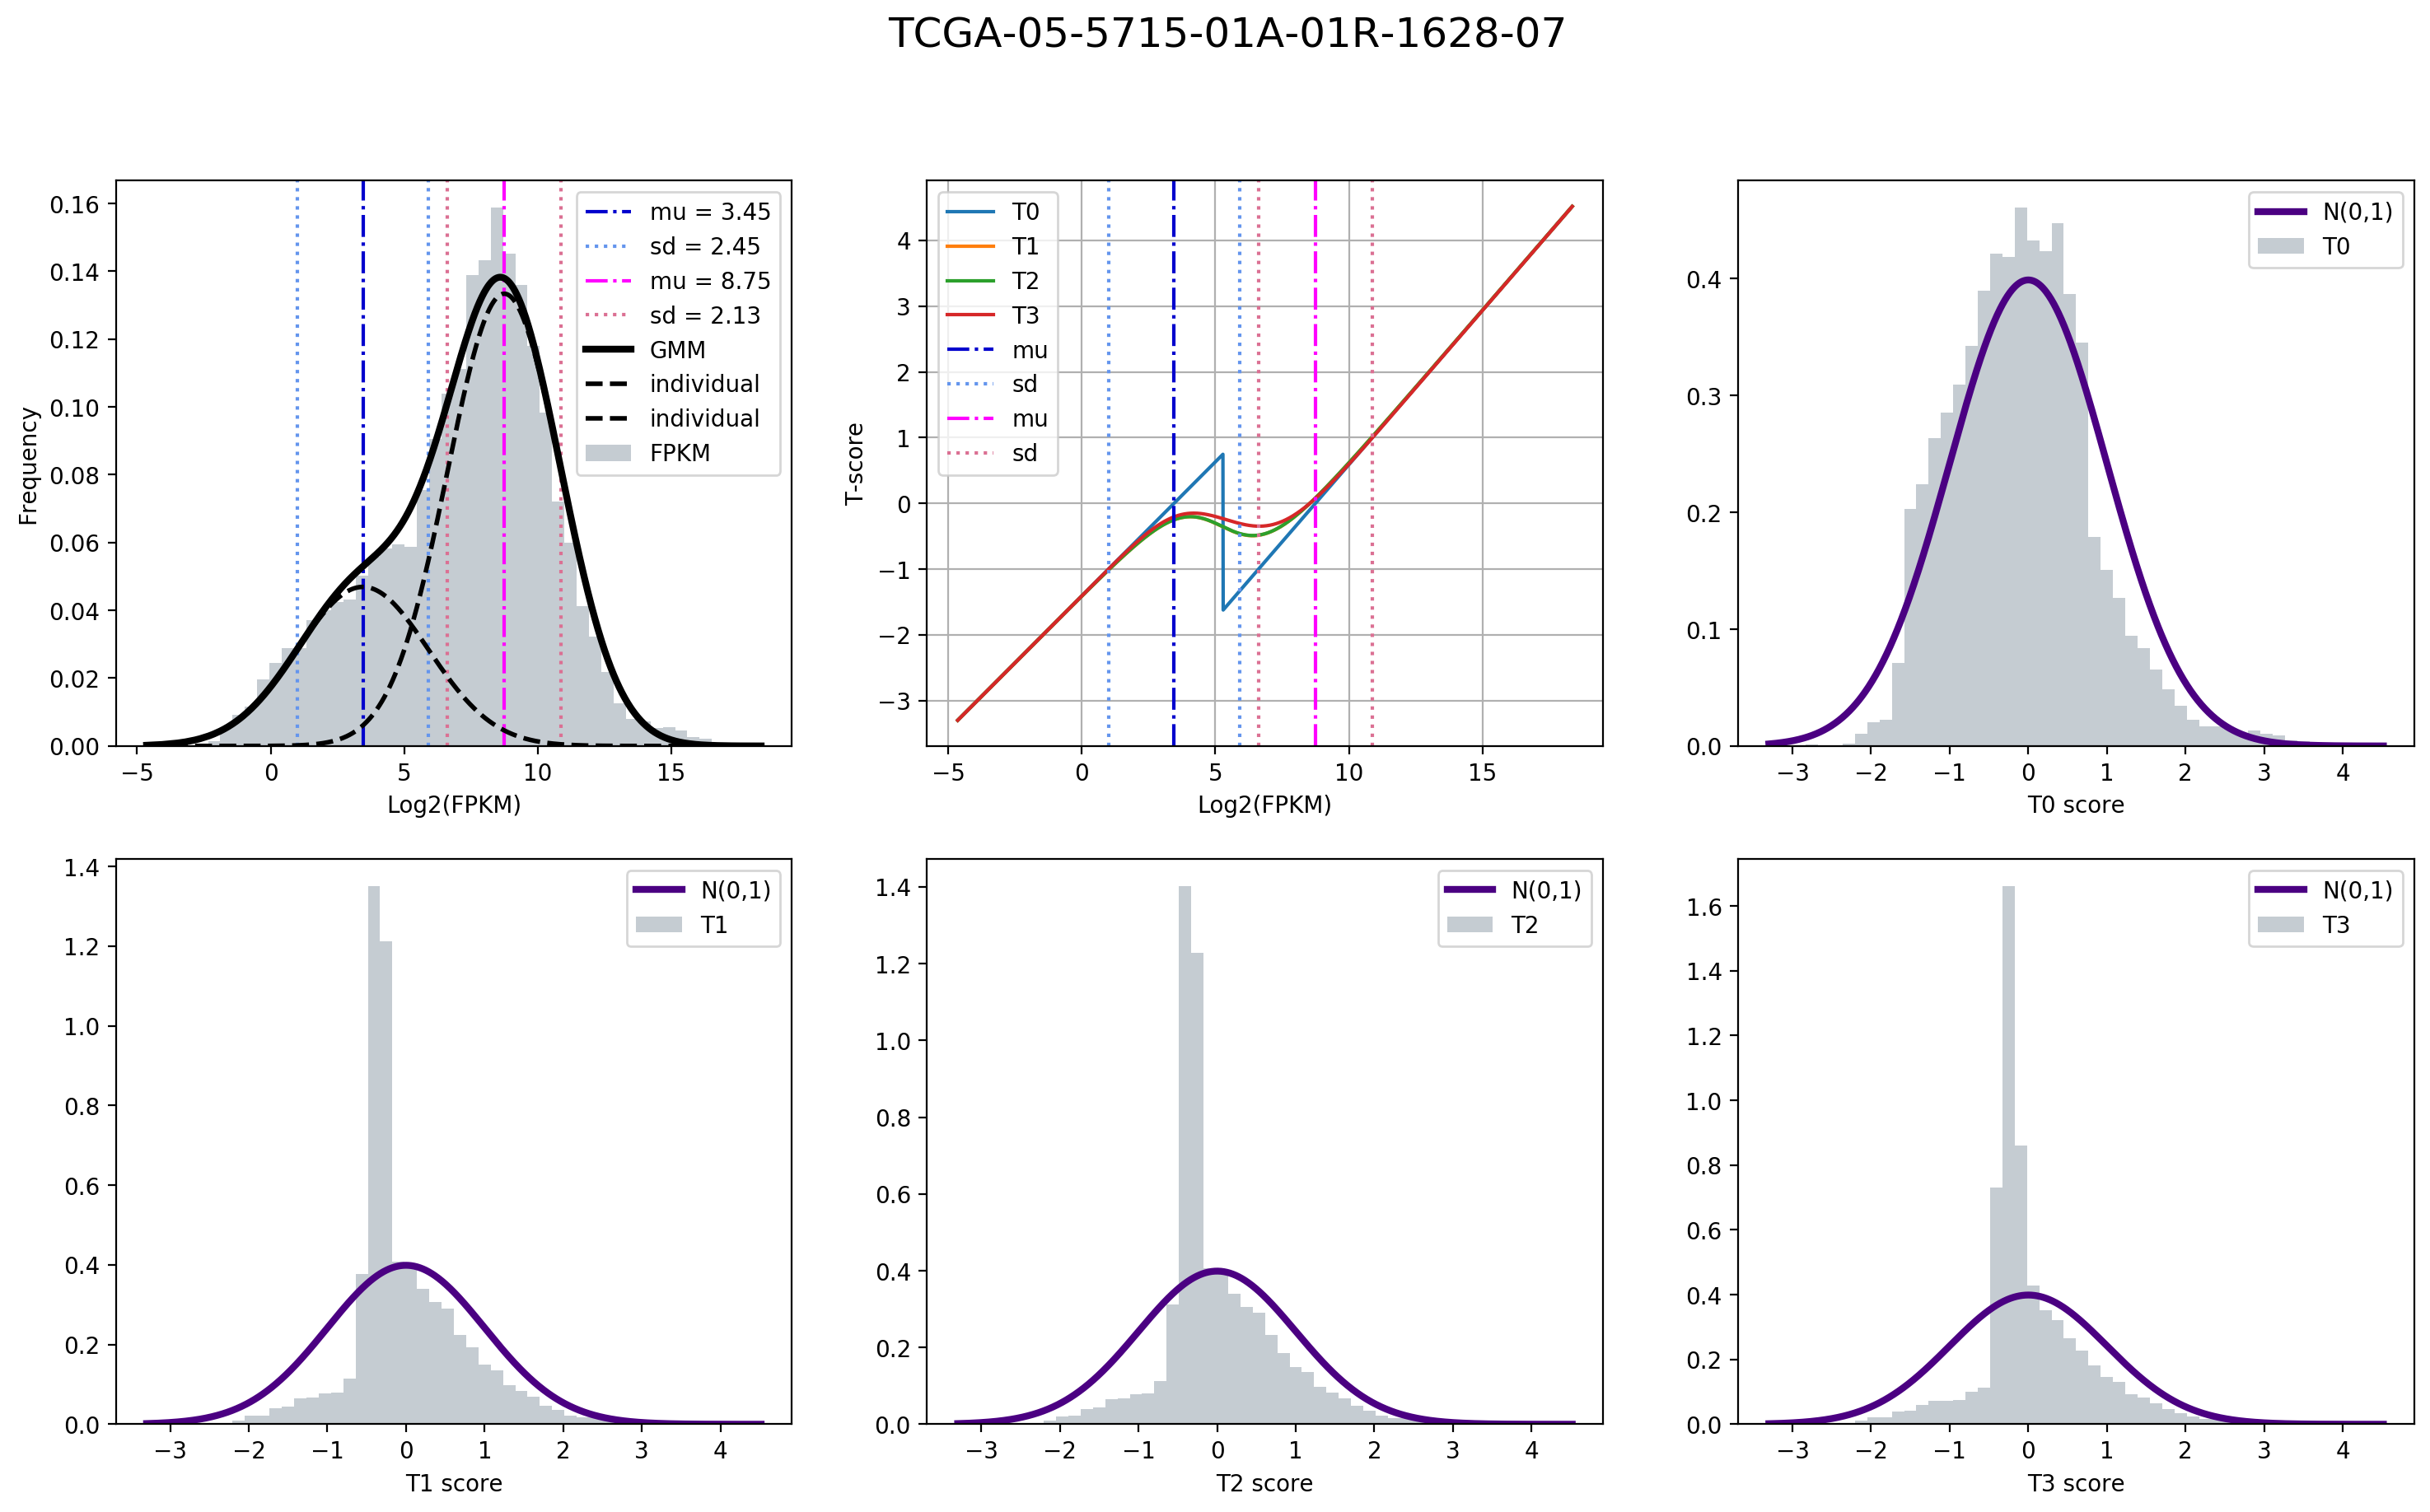

The details of parameters and $T$-score computation are explained below

- `tdf`: list with 4 data frames: $T_0, T_1, T_2, T_3$
- `gmm`: list with the GMM parameters used for each subject. 
- `cutoff`: Expression levels below the cutoff value will be treated as zero
- `n_components`: Number of independent Gaussians to use for the GMM
- `data_label`: string: just for plot purposes, if the plots should say `FPKM` or `TPM` or something else
- `dpi`: resolution of the generated plots (if any). Keep it below 100
- `print_plot`: bool. Should plots be printed on the notebook? Only useful if plotting one particular subject.
- `save_fig`: bool. Should plots be saved? If so, save them in the `dst` directory
     - If `print_plot=False`, the `save_fig` option is ignored
- `dst`: directory to save the generated plots (if any).

- If you want to save a summary picture for each subject, add `print_plot=True` to the `gmm_tscores` function inside the loop.

### Notes

- There is a randomness element when computing GMMs.
- To keep results consistent, the random seed is fixed when computing GMM
    - This is done by `random_state=42` inside the `gmm_fit` function
    - `42` is a completely arbitrary choice
- If you are **not** plotting/saving the summaries, it shouldn't take more than 5 mins.
- If you **are** plotting/saving, it will take a while

In [7]:
tdf = [fpkm_data.copy() for i in range(4)]
gmm = [None for i in range(fpkm_data.shape[1])]

cutoff = 2**-15
n_components=2
data_label = 'FPKM'
dpi=100
print_plot=False

for i in range(1,fpkm_data.shape[1],1):
    sample = fpkm_data.iloc[:,i]
    tscore, gmm[i] = tumor.gmm_tscores(sample, cutoff, n_components, data_label=data_label, 
                               print_plot=print_plot, dpi=dpi, dst=dst)
    for j in range(len(tscore)):
        tdf[j][sample.name] = tscore[j]
    

In [8]:
# Save the scores
    
for i in range(len(tdf)):
    tdf[i].to_csv(src+'data/' + cancer_type + '_T{}.csv'.format(i), 
                  float_format="%.5f", index=False)

### Automatically detect if the GMM is a good fit


- `gmm`: list with the GMM parameters used for each subject. The parameters are recorded as a dictionary in each case. The keys for each dictionary are:
    - `pdf`: Nx1 array probability distribution function
    - `pdf_individual`: Nx2 array with the individual pdfs
    - `weights`: Nx2 array with the weights of each Gaussian at each point
    - `means`: the mean of each individual Gaussian
    - `stdeviations`: the std of each individual Gaussian

### Automatically detect if the GMM is a good fit

- We can check how far apart are the Gaussian means
- How much overlap is there between the standard deviations

- We must make sure that the first Gaussian corresponds to the one with the smaller mean

In [10]:
def gmm_gap_measure(gmm):
    means = np.argsort(gmm['means'])

    a,b = (gmm['means'] - gmm['stdeviations'])[means]
    c,d = (gmm['means'] + gmm['stdeviations'])[means]
    
    dmeans = np.abs(gmm['means'][0] - gmm['means'][1])
    separation = b-c
    gap = np.max([c-b, 0])
    overA = gap/(c-a)
    overB = gap/(d-b)
    overlap = np.max([overA, overB])

    return dmeans, separation, overlap

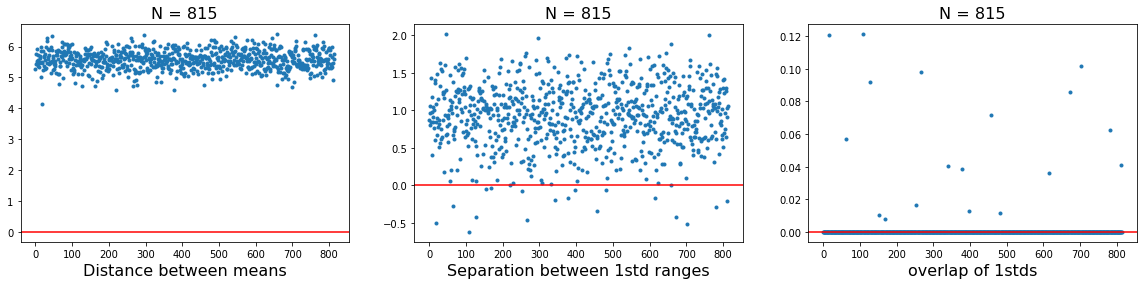

In [38]:
gap_measure = np.zeros((len(gmm),3))
for i in range(1,len(gmm)):
    gap_measure[i,:] = gmm_gap_measure(gmm[i])
    
fig, ax = plt.subplots(1,3,figsize=(20,4))
xlabel = ['Distance between means', 'Separation between 1std ranges', 'overlap of 1stds']

for i in range(len(ax)):
    ax[i].plot(gap_measure[1:,i], '.')
    ax[i].axhline(0,c='r')
    ax[i].set_title('N = {}'.format(len(gmm)), fontsize=16)
    ax[i].set_xlabel(xlabel[i], fontsize=16)

From the plots above, we can say that most of the individual Gaussians are separated, from which we can asume that GMM is a good model for most of the subjects

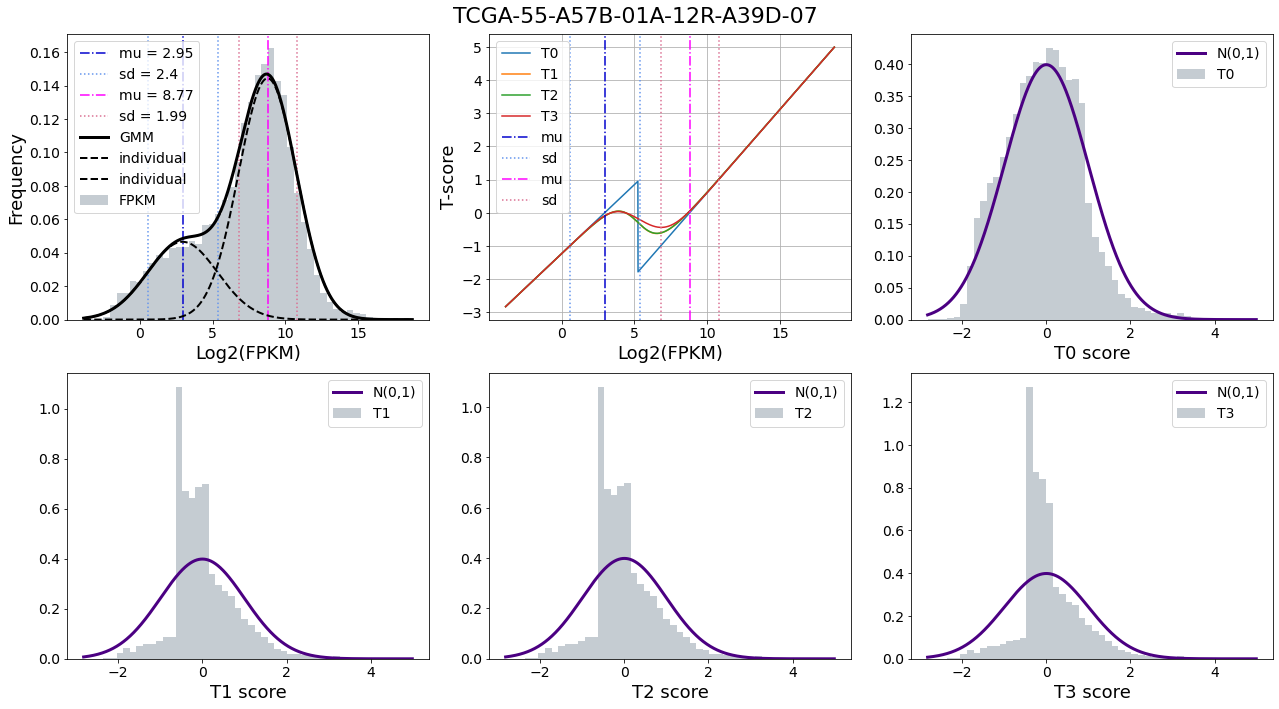

In [21]:
tumor.plot_tsummary(dst, sample, x, T, gmm, data_label='FPKM', show_fig=True, dpi=100)